# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Excercises](#excercises)

    a. [Edge detection](#edgeDetection)
    
    b. [Image enhancement and image masking](#imageandmasking)
    
    c. [PET Image Enhancement](#medianFilters)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [5]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [6]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

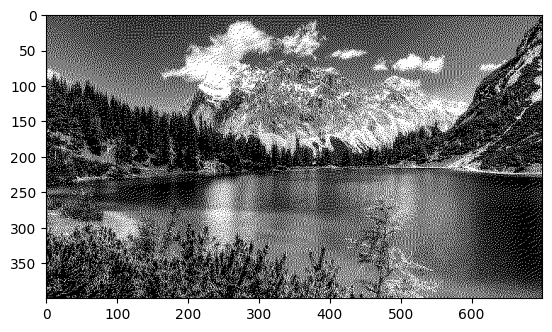

In [7]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [8]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

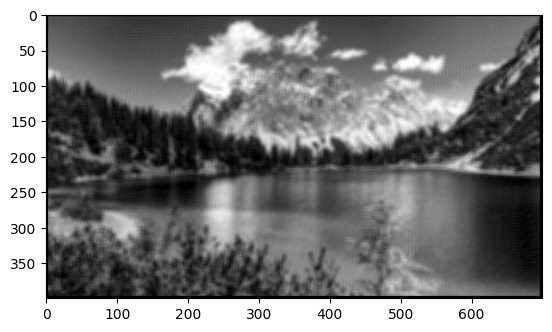

In [9]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [10]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

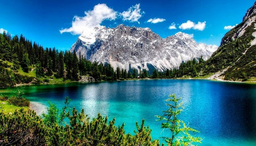

In [11]:
img

In [13]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [14]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [15]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

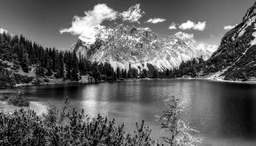

In [16]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [17]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [18]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0008,  0.0100,  0.0099,  ...,  0.0122,  0.0371,  0.1503],
         [ 0.0017,  0.0805,  0.0813,  ...,  0.1232,  0.1750,  0.1756],
         [ 0.0017,  0.0849,  0.0836,  ...,  0.1757,  0.1461,  0.1435],
         ...,
         [ 0.0097, -0.0294,  0.0751,  ...,  0.0902,  0.0812,  0.2132],
         [-0.0401,  0.0466,  0.0898,  ...,  0.0967,  0.0887,  0.2387],
         [-0.0362, -0.0026, -0.0170,  ..., -0.0224, -0.0267,  0.0562]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [19]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [20]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [21]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [22]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

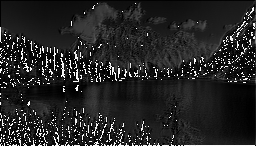

In [23]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

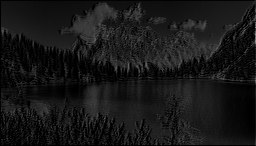

In [24]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [25]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

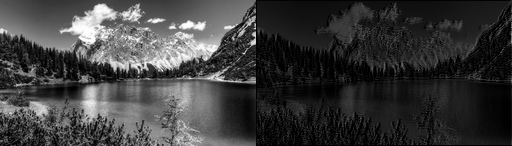

In [26]:
display(input, output)

### Identity

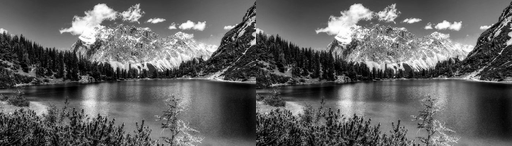

In [27]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


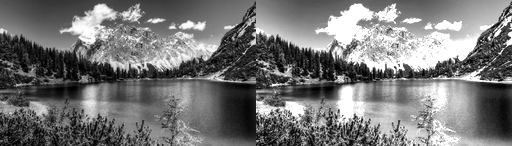

In [30]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


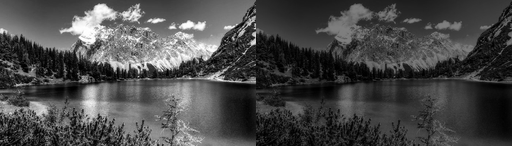

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


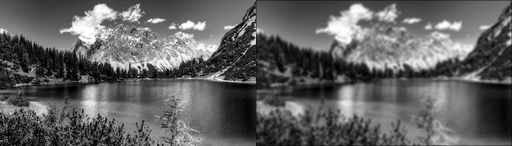

In [32]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


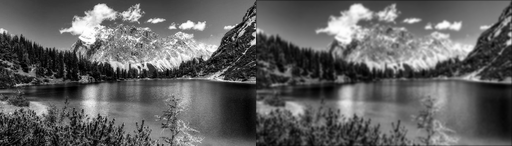

In [33]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


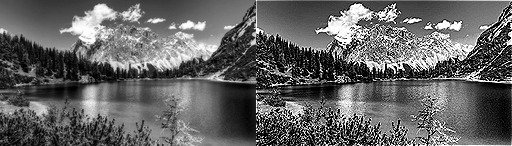

In [34]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


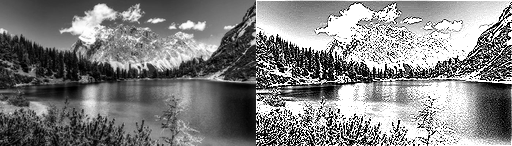

In [35]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


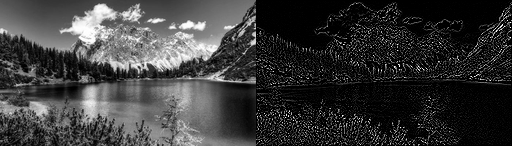

In [36]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

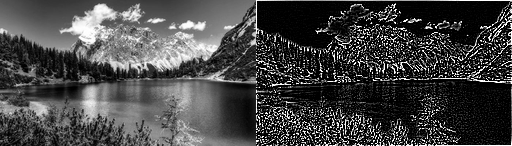

In [37]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

## Excercises <a class="anchor" id="excercises" ></a>

### 1. Edge detection algorithm implementation  <a class="anchor" id="edgeDetection" ></a>

In [22]:
# Function to plot images
def plot_images(orig_img, trans_img):
    plt.figure(figsize=([20, 20]))
    plt.subplot(121),plt.imshow(orig_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(trans_img)
    plt.title('Transformed Image'), plt.xticks([]), plt.yticks([])
    
# Function to plot original and grayscaled Image
def plot_images_gray(orig_img, gray_img):
    plt.figure(figsize=([20, 20]))
    plt.subplot(121),plt.imshow(orig_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(gray_img, cmap=plt.get_cmap('gray'))
    plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
    
# Function to plot original, grayscaled and Edge Detected Images
def plot_images_edgeDetection(orig_img, gray_img, edge_img):
    plt.figure(figsize=([40, 40]))
    plt.subplot(131),plt.imshow(orig_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(gray_img, cmap=plt.get_cmap('gray'))
    plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(edge_img, cmap=plt.get_cmap('gray'))
    plt.title('Edge Detected Image'), plt.xticks([]), plt.yticks([])

#### Prewitt

In [ ]:
# https://github.com/abhilas0/edge_detection/blob/master/edge_detection.ipynb

#define horizontal and Vertical sobel kernels
Hx = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
Hy = np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]])

#### Sobel

In [16]:
# First we read our image file and converted to gray scale.
img = Image.open('data/tiger.jpeg')

# Then we convert our image to a numpy array where the height, width and colors are separated so we can use them later
img = np.array(img)

# Then we separate the RGB colors on individual variables.
redCh, greenCh, blueCh = img[:, :, 0], img[:, :, 1], img[:, :, 2]

# As we are not allowed to use libraries, we apply a Gamma filter to convert our image to grayscal.
# If we recall the gamma correctionwill let us play with the luminance and contrast of the image,
# By elevating our array to an specific value and multiplying it by the specified gamma parameter.
# A gamma > 1 is called decodin g and with help us to change the color of our image to grayscale.

gamma_val = 1.400 

# We also need to add specific weights for each RGB channel, this values are the ones being multiploed on the Gamma correction formula.
# We found this values through research as the ideal for this convertion to an optimized image and greyscale convertion.

redConst, greenConst, blueConst = 0.2126, 0.7152, 0.0722 
grayimg = redConst * redCh ** gamma_val + greenConst * greenCh ** gamma_val + blueConst * blueCh ** gamma_val


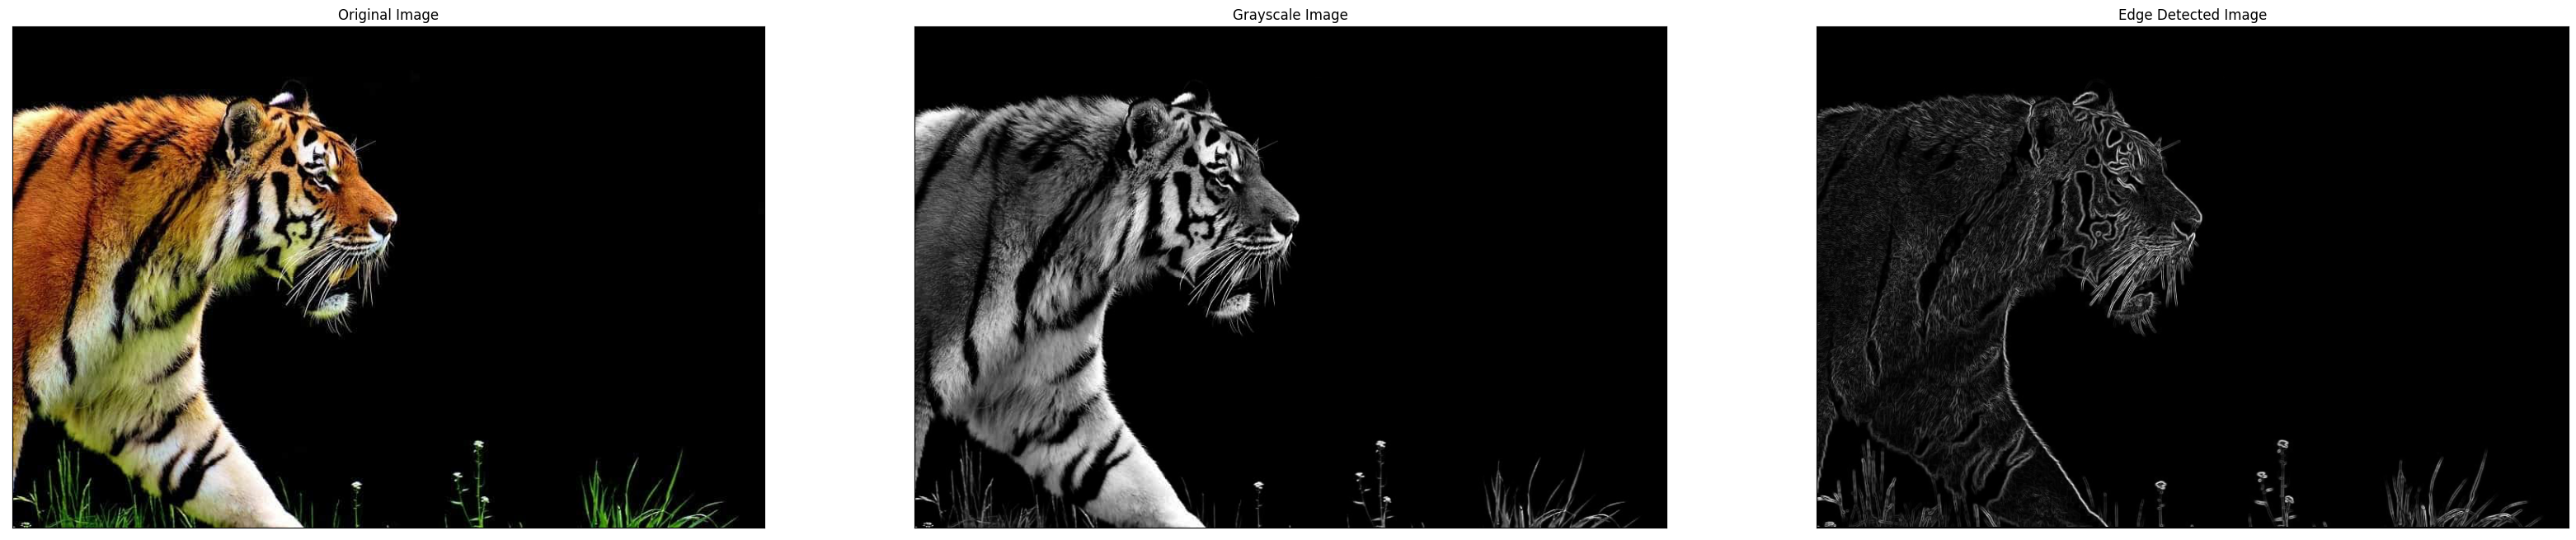

In [23]:
"""
Now that we got our image on a grayscale mode, we need to apply the Sobel Filter to detect the Edges on it.
As we can remember for the lectures, a Sobel Operator is a specific type of 2D derivative mas which is efficient in
detecting the edges of an image. When using this 2D spatial gradient mesuarement of an image, it helps to emphasize regions of high spatial frequency
which correspond to edges.


Sobel operator works by applying the operator that consists of a pair of 3x3 convolution kernels.
One kernel is simply the other rotated by 90°. One of the kernels is applied to the X (horizontal) direction and the other 
is applied to the Y (Vertical) direction. 

As an example we could define the following:
      _               _                   _                _
     |                 |                 |                  |
     | -1.0   0.0  1.0 |                 | -1.0  -2.0  -1.0 |
Gx = | -2.0   0.0  2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | -1.0   0.0  1.0 |                 |  1.0   2.0   1.0 |
     |_               _|                 |_                _|
"""

# Naturally the first step will be to define our kernels onto 2D arrays
kernX = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
kernY = np.array([[-1.0, -2.0, -1.0], [0.0, 0.0, 0.0], [1.0, 2.0, 1.0]])

# Then our next step is to obtain the shape of our grayscale image, wich will help us on initialize a numpy array with all elements as 0,
# In this numpy array we will be saving the sobel filter image we build.
[r, col] = np.shape(grayimg)  
sobelImg = np.zeros(shape=(r, col)) 

# Next we go though the x and y values of our image
# then we store the computed value of the sobel transformation on the corresponding position on our empty array.
for i in range(r - 2):
    for j in range(col - 2):
        # To find the Gradient on each direction, we multiply each of our kernels to the corresponding pixel grid of our image.
        # We apply this operation separetly to produce a measure of the gradient component in each orientation. 
        gx = np.sum(np.multiply(kernX, grayimg[i:i + 3, j:j + 3]))  
        gy = np.sum(np.multiply(kernY, grayimg[i:i + 3, j:j + 3]))  
        # Finally we find the absolute magnitude of the gradient at each point, which is given by the square root of the the gradient's square addition.
        sobelImg[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2) 

plot_images_edgeDetection(img, grayimg, sobelImg)


#### Laplacian

In [ ]:
# https://iq.opengenus.org/laplacian-filter/

def create_log(sigma, size = 7):
    w = math.ceil(float(size)*float(sigma))

    if(w%2 == 0):
        w = w + 1

    l_o_g_mask = []

    w_range = int(math.floor(w/2))
    print("Going from " + str(-w_range) + " to " + str(w_range))
    for i in range_inc(-w_range, w_range):
        for j in range_inc(-w_range, w_range):
            l_o_g_mask.append(l_o_g(i,j,sigma))
    l_o_g_mask = np.array(l_o_g_mask)
    l_o_g_mask = l_o_g_mask.reshape(w,w)
    return l_o_g_mask

### 2. Image enhancement and image masking <a class="anchor" id="imageandmasking" ></a>

In [89]:
import cv2 
import numpy as np

def line_enhancement(img, alpha=1.5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=50, maxLineGap=10)
    mask = np.zeros_like(gray) 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(mask, (x1,y1), (x2,y2), (255,255,255), 2)
            
    enhanced = cv2.addWeighted(img, alpha, mask, 1-alpha, 0)
    return enhanced 



img = cv2.imread("data/elon_1.jpg") 
    
enhanced_img = line_enhancement(img, 1)
cv2.imshow("Original Image", img)
cv2.imshow("Enhanced Image", enhanced_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


### 3. Median filtering  <a class="anchor" id="medianFilters" ></a>

In [65]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

def gaussian_kernel(size, sigma):
    size = int(size) // 2 
    x, y = np.mgrid[-size:size+1, -size:size+1] 
    normal = 1 / (2.0 * np.pi * sigma**2) 
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal 
    return g 

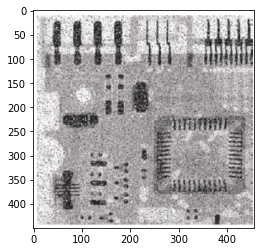

In [72]:
image = cv2.imread("data/pcb_noisy.png") 
plt.imshow(image)

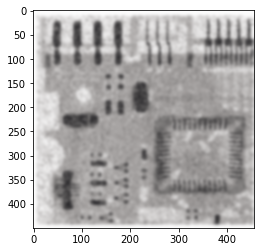

In [76]:

kernel = gaussian_kernel(17, 3)
blurred_image = cv2.filter2D(image, -1, kernel)
plt.imshow(blurred_image)

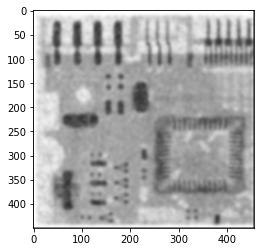

In [74]:
# Obtain the number of rows and columns 
# of the image
blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

m, n = blurred_image.shape
   
# Traverse the image. For every 3X3 area, 
# find the median of the pixels and
# replace the center pixel by the median
image_median = np.zeros([m, n])
  
for i in range(1, m-1):
    for j in range(1, n-1):
        temp = [blurred_image[i-1, j-1],
               blurred_image[i-1, j],
               blurred_image[i-1, j + 1],
               blurred_image[i, j-1],
               blurred_image[i, j],
               blurred_image[i, j + 1],
               blurred_image[i + 1, j-1],
               blurred_image[i + 1, j],
               blurred_image[i + 1, j + 1]]
        
        temp = sorted(temp)
        image_median[i, j]= temp[4]


plt.imshow(image_median, cmap='gray')



In [48]:
image_median.shape

(450, 456)

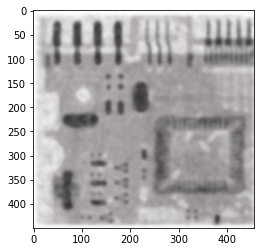

In [80]:
kernel_size = (7, 7) 
image_median = cv2.medianBlur(blurred_image, kernel_size[0])

plt.imshow(image_median, cmap='gray')